In [43]:
import numpy as np
import matplotlib.pyplot as plt
import odl


### 2D Shepp Logan Phantom test

(-0.5, 255.5, 255.5, -0.5)

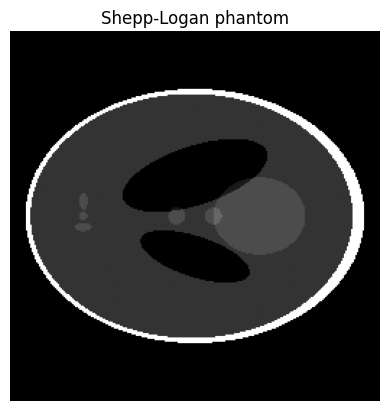

In [44]:
space = odl.uniform_discr(
    min_pt=[-1, -1],
    max_pt=[1, 1],
    shape=[256, 256],
    dtype='float32'
)

phantom = odl.phantom.shepp_logan(space, modified=True)
plt.imshow(phantom, cmap='gray')
plt.title("Shepp-Logan phantom")
plt.axis("off")


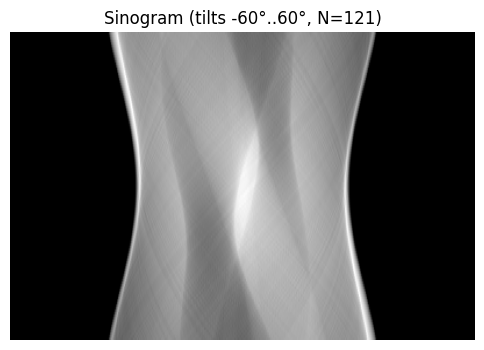

In [45]:
angular_coverage = (-60, 60)  # degrees
step = 1  # degree step

a0, a1 = np.deg2rad(angular_coverage[0]), np.deg2rad(angular_coverage[1])
n_angles = int((angular_coverage[1] - angular_coverage[0]) / step) + 1  # 121

angles = odl.uniform_partition(a0, a1, n_angles)
det = odl.uniform_partition(-1.5, 1.5, 400)
geom = odl.tomo.Parallel2dGeometry(angles, det)

A = odl.tomo.RayTransform(space, geom, impl="astra_cuda")
sino = A(phantom)

plt.figure(figsize=(6,4))
plt.imshow(sino, cmap="gray", aspect="auto")
plt.title(f"Sinogram (tilts {angular_coverage[0]}°..{angular_coverage[1]}°, N={n_angles})")
plt.axis("off")
plt.show()


### Fourier SIAC filter with the FBP

**Regular FBP**
\begin{align}
    \text{FBP} = A^* \mathcal{F}^{-1}\big[ |\omega|W(\omega) \mathcal{F}[\cdot] \big]
\end{align}

Where $A^*$ is the adjoint to the X-ray transform, $\mathcal{F}$ is the Fourier transform and $W$ is a window (e.g. Shepp-Logan or Hann).

**FBP with SIAC**
\begin{align}
    \text{FBP} = A^* \mathcal{F}^{-1}\big[ \underbrace{|\omega|W(\omega)}_{\text{standard FBP}} \underbrace{\widehat{S}(\omega)}_{\text{SIAC}} \mathcal{F}[\cdot] \big]
\end{align}

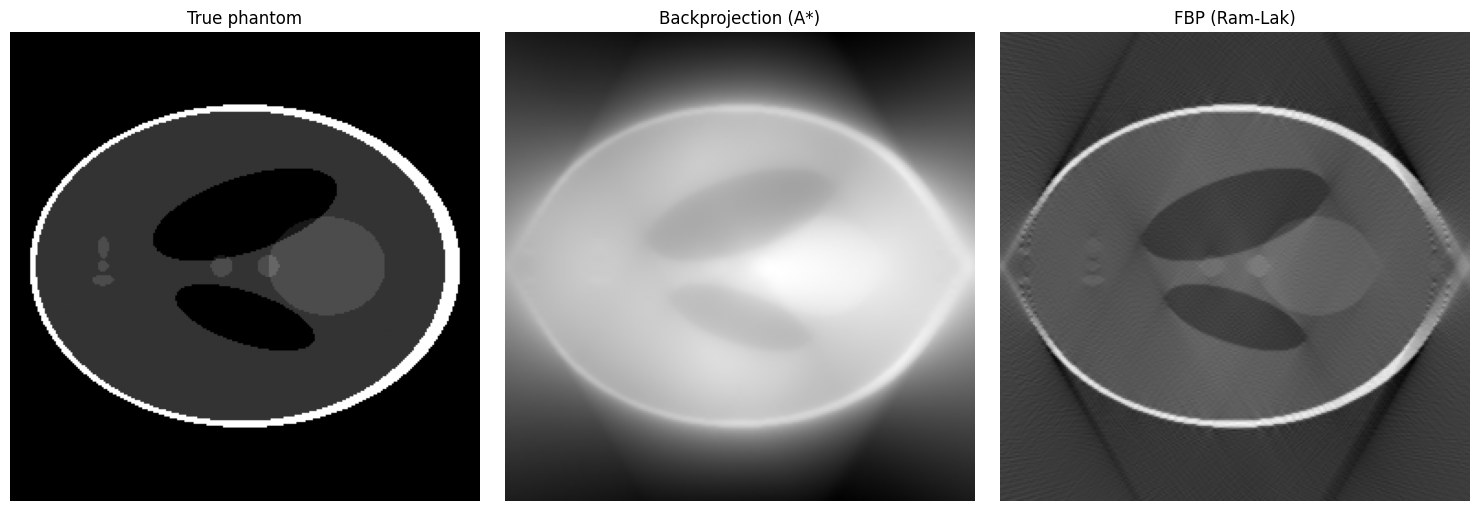

In [46]:
# Backprojection (adjoint)
bp = A.adjoint(sino)

# Filtered backprojection
# Availible filters: 'Ram-Lak', 'Shepp-Logan', 'Cosine', 'Hamming', 'Hann'
filter_used = "Ram-Lak"
fbp_op = odl.tomo.fbp_op(A, filter_type=filter_used)
fbp = fbp_op(sino)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(phantom, cmap="gray"); ax[0].set_title("True phantom"); ax[0].axis("off")
ax[1].imshow(bp, cmap="gray"); ax[1].set_title("Backprojection (A*)"); ax[1].axis("off")
ax[2].imshow(fbp, cmap="gray"); ax[2].set_title(f"FBP ({filter_used})"); ax[2].axis("off")
plt.tight_layout()
plt.show()


### Test with Poisson noise

### And Gaussian noise

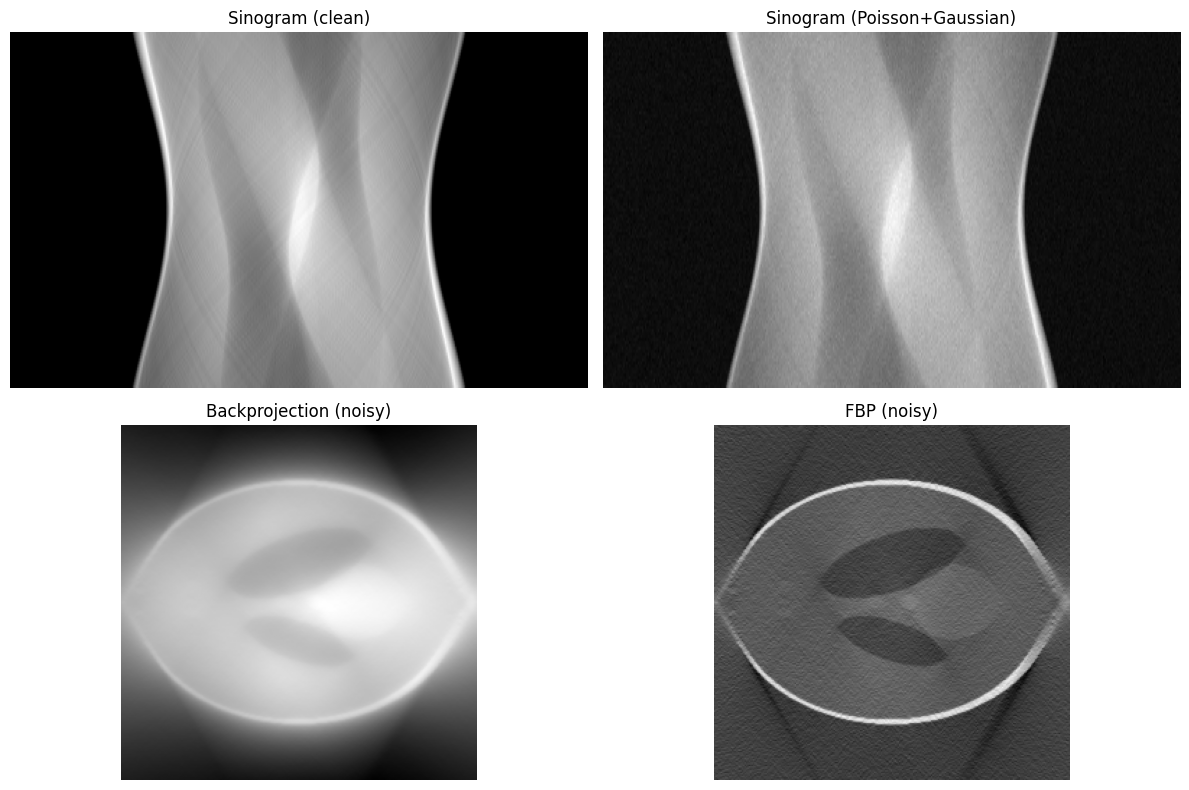

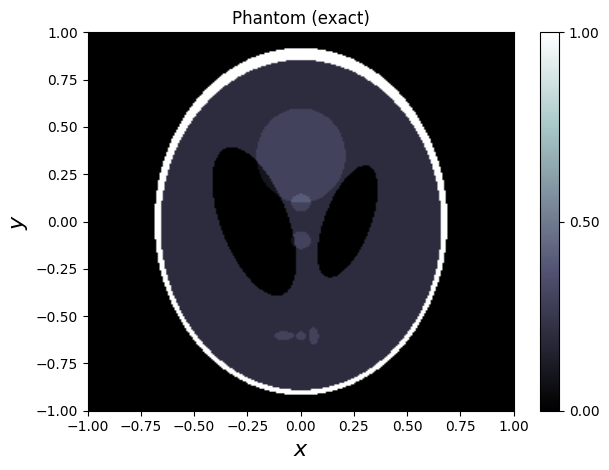

<Figure size 640x480 with 0 Axes>

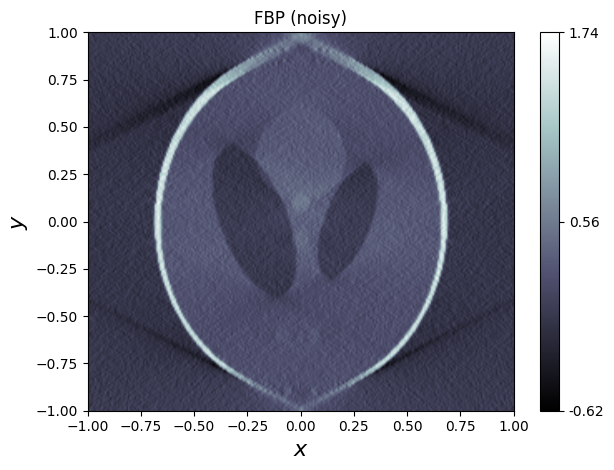

<Figure size 640x480 with 0 Axes>

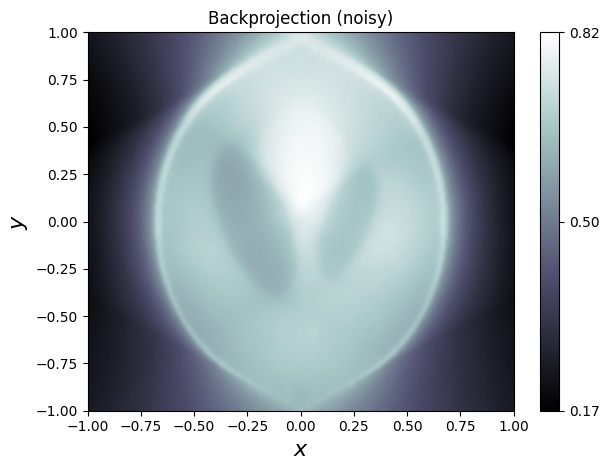

<Figure size 640x480 with 0 Axes>

In [47]:
from odl.phantom.noise import poisson_noise, white_noise

# Clean sinogram as ODL element and NumPy array
p_clean = sino.asarray()

I0 = 2e4
sigma = 3.0  # counts

# Expected counts (ODL element in A.range)
lam = A.range.element(I0 * np.exp(-p_clean))

# Poisson + optional Gaussian (both in A.range)
I = poisson_noise(lam, seed=0)
I = I + white_noise(A.range, mean=0.0, stddev=sigma, seed=1)

# Clamp in numpy (avoid log problems)
I_arr = np.maximum(I.asarray(), 1.0)

# Noisy log-sinogram (ODL element)
sino_noisy = A.range.element(-np.log(I_arr / I0))
p_noisy = sino_noisy.asarray()

# Recon
bp_noisy  = A.adjoint(sino_noisy)
fbp_noisy = fbp_op(sino_noisy)

fig, ax = plt.subplots(2, 2, figsize=(12, 8))

ax[0, 0].imshow(sino.asarray(), cmap="gray", aspect="auto")
ax[0, 0].set_title("Sinogram (clean)")
ax[0, 0].axis("off")

ax[0, 1].imshow(sino_noisy.asarray(), cmap="gray", aspect="auto")
ax[0, 1].set_title(f"Sinogram (Poisson+Gaussian)")
ax[0, 1].axis("off")

ax[1, 0].imshow(bp_noisy.asarray(), cmap="gray")
ax[1, 0].set_title("Backprojection (noisy)")
ax[1, 0].axis("off")

ax[1, 1].imshow(fbp_noisy.asarray(), cmap="gray")
ax[1, 1].set_title("FBP (noisy)")
ax[1, 1].axis("off")

plt.tight_layout()
plt.show()


phantom.show(title="Phantom (exact)")
fbp_noisy.show(title="FBP (noisy)")
bp_noisy.show(title="Backprojection (noisy)")
plt.show()

